# Ensemble model methods

## Dataset download

In [1]:
# cd data
# kaggle datasets download -d fedesoriano/stroke-prediction-dataset

In [113]:
import pandas as pd
import numpy as np
from pathlib import Path

data_IN = pd.read_csv(Path('.')/'data'/'stroke-prediction-dataset.zip')

data_IN.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data_IN.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
data_IN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Column `bmi` contains null values. Give values using a ML model

In [5]:
from sklearn.model_selection import train_test_split

data_IN_2 = data_IN.drop('stroke',axis=1)

bmi_mask = data_IN_2['bmi'].isna()

df_bmi_P = data_IN_2.loc[~bmi_mask,:]
df_bmi_A = data_IN_2.loc[bmi_mask,:]

df_bmi_P_target = df_bmi_P['bmi']
df_bmi_P = df_bmi_P.drop(['bmi'],axis=1)

df_bmi_P_train, df_bmi_P_test, df_bmi_P_target_train, df_bmi_P_target_test = train_test_split(
    df_bmi_P,
    df_bmi_P_target,
    shuffle=True,
    random_state=42
)

df_bmi_P_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status
795,60777,Female,31.0,0,0,Yes,Govt_job,Rural,103.55,formerly smoked
3031,65688,Male,2.0,0,1,No,children,Urban,62.89,Unknown
2438,61010,Female,60.0,0,0,Yes,Private,Urban,114.34,smokes
2043,15225,Male,18.0,0,0,No,Private,Rural,108.87,Unknown
2032,57263,Female,54.0,0,0,Yes,Private,Urban,100.29,never smoked


Naive bmi attribution with mean value of bmi

In [6]:
df_IN = data_IN.copy().drop('id',axis=1)
df_IN['bmi'] = df_IN['bmi'].fillna(df_IN['bmi'].mean())
df_IN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Number of records per class


In [7]:
df_IN.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Visualize the numerical features

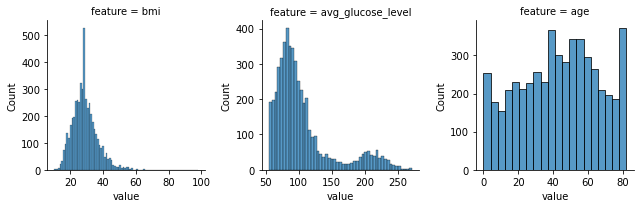

In [8]:
import seaborn as sns

df_to_plot = df_IN.loc[:,['bmi','avg_glucose_level','age']]

df_to_plot = df_to_plot.stack()

df_to_plot.name = 'value'

df_to_plot = df_to_plot.droplevel(0,axis=0).to_frame().reset_index()

df_to_plot = df_to_plot.rename({'index':'feature'},axis=1)

hist_grid = sns.FacetGrid(
    df_to_plot,
    col='feature',
    sharex=False,
    sharey=False
)
hist_grid.map(sns.histplot,'value')


### Baseline

#### Creation of train/valid and test sets

In [69]:
from sklearn.model_selection import train_test_split

df_features = df_IN.drop('stroke',axis=1)
df_target = df_IN.loc[:,['stroke']]

df_train, df_test, target_train, target_test = train_test_split(
    df_features, df_target,
    test_size=0.1,
    shuffle=True,
    stratify=df_target,
    random_state=42
)

print(target_train['stroke'].value_counts())
print(target_test['stroke'].value_counts())

0    4375
1     224
Name: stroke, dtype: int64
0    486
1     25
Name: stroke, dtype: int64


Train/test with resampling

In [139]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

def custom_resampler(df_features, df_target, n_samples=1000, test_size=0.1):

    df_train, df_test, target_train, target_test = train_test_split(
        df_features, df_target,
        test_size=0.1,
        shuffle=True,
        stratify=df_target,
        random_state=42
    )

    mask_class_1 = target_train['stroke'] == 1

    df_train_class_1, target_train_class_1 = df_train.loc[mask_class_1,:], target_train.loc[mask_class_1,:]

    df_train_class_1_resampled, target_train_class_1_resampled = resample(
        df_train_class_1, target_train_class_1,
        n_samples=n_samples
    )

    df_train_resampled = pd.concat(
        [df_train.loc[~mask_class_1], df_train_class_1_resampled]
    )

    target_train_resampled = pd.concat(
        [target_train.loc[~mask_class_1], target_train_class_1_resampled]
    )

    return df_train_resampled, df_test, target_train_resampled, target_test

df_train_resampled, df_test, target_train_resampled, target_test = custom_resampler(df_features,df_target)


print(df_features.shape)
print(df_target['stroke'].value_counts())
print(df_train_resampled.shape)
print(target_train_resampled['stroke'].value_counts())
print(df_test.shape)
print(target_test['stroke'].value_counts())

(5110, 10)
0    4861
1     249
Name: stroke, dtype: int64
(6375, 10)
0    4375
1    2000
Name: stroke, dtype: int64
(511, 10)
0    486
1     25
Name: stroke, dtype: int64


#### Definition of the transfromations

In [95]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer # test different scaler
from sklearn.pipeline import Pipeline

col_trans = ColumnTransformer(
    [
        ('onehot_encoder', OneHotEncoder(sparse=False), ['gender','ever_married','work_type','Residence_type','smoking_status']),
        ('minmax_scaler', MinMaxScaler(), ['age']),
        ('pwr_transformer', PowerTransformer(), ['bmi','avg_glucose_level'])
    ],
    remainder='passthrough',
    n_jobs=6,
    verbose=True,
    verbose_feature_names_out=False
)

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

log_reg = LogisticRegression()
svc = SVC()
bern_nb = BernoulliNB()
rnd_forest = RandomForestClassifier()
hist_grad = HistGradientBoostingClassifier()
kn_class = KNeighborsClassifier()
xgb_class = XGBClassifier()
lgbm_class = LGBMClassifier(
    n_estimators=200,
    n_jobs=6,
    # colsample_bytree=.9
)

pipe1 = Pipeline(
    [
        ('col_trans', col_trans),
        # ('log_reg', log_reg)
        # ('svc', svc)
        # ('bern_nb', bern_nb)
        # ('kn_class', kn_class)
        # ('rnd_forest', rnd_forest)
        # ('hist_grad', hist_grad)
        # ('xgb_class', xgb_class)
        ('lgbm_class', lgbm_class)
    ]
)

In [150]:
from sklearn.metrics import classification_report, f1_score

f1_macro_results = []

for num, n_samples in enumerate(np.arange(400,2000,100)):

    df_train_resampled, df_test, target_train_resampled, target_test = custom_resampler(df_features, df_target, n_samples, test_size=.1)

    model = pipe1.fit(df_train_resampled, target_train_resampled.values.ravel())

    preds = model.predict(df_test)

    class_report = classification_report(target_test.values.ravel(),preds)
    class_f1_macro = f1_score(target_test.values.ravel(),preds,average='macro')

    f1_macro_results.append(class_f1_macro)

    print(f'{num}.\tn_samples: {n_samples}', end='\r')

print(f1_macro_results)

[0.5508935256013802, 0.5436413431769469, 0.574065253631817, 0.5105363984674329, 0.5681203515889114, 0.5393283750281722, 0.5414387031408308, 0.5626872058194266, 0.5601377259566477, 0.537302785018521, 0.574065253631817, 0.5299221799557445, 0.5576883910386966, 0.55087060835689, 0.5837067209775968, 0.5334794063176566]


## Stacking models manually optimizing the AUC
Source: [Approaching (Almost) Any Machine Learning Problem](https://github.com/abhishekkrthakur/approachingalmost)

In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.optimize import fmin

class OptimizeAUC:
    '''
    Class for optimizing AUC
    '''
    def __init__(self):
        self.coef_ = 0

    def _auc(self, coef, X, y):
        '''
        Function that returns the AUC.
        :param coef: coef list, i.e., the weights used to ensemble the model predictions (probabilities)
        :param X: predictions
        :param y: targets
        '''
        # Compute the weighted model predictions by multiplying the predictions of the single models by the coefficient array
        x_coef = X * coef

        # Compute the overall prediction as the sum of the weighted predictions
        predictions = np.sum(x_coef, axis=1)

        # Compute AUC score
        auc_score = roc_auc_score(y, predictions)

        # To maximize AUC return -AUC
        return -1.0 * auc_score
    
    def fit(self, X, y):
        '''
        Function that computes the coefficient values that maximize the AUC of the ensembled models
        :param X: predictions
        :param y: targets
        '''
        # Define the loss function, that, in this case, is the (-1.0*) AUC
        loss = self._auc

        # Initialize the coefficients
        init_coef = np.random.dirichlet(np.ones(X.shape[1]),size=1)

        # Minimize the loss
        self.coef_ = fmin(func=loss,x0=init_coef,args=(X,y))

    def predict(self, X):
        # Compute the weighted predictions by multiplying the predictions of the single models by the coefficient array found minimizing the AUC
        x_coef = X * self.coef_

        predictions = np.sum(x_coef,axis=1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    shuffle=True,
    test_size=.9
)

array([0.61045213, 0.38954787])